---
## 1. Setup and Data Loading

In [1]:
# ============================================
# IMPORT LIBRARIES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported")

✅ Libraries imported


In [2]:
# ============================================
# LOAD DATA
# ============================================

df = pd.read_csv('../data/raw/Output_10yrs_reported_schools_17220.csv')

# Rename columns
df = df.rename(columns={
    'Survey Year': 'Year',
    'Institution Name': 'Institution_Name',
    'State CD': 'State',
    'Classification Name': 'Classification'
})

# Sort for proper lag calculations
df = df.sort_values(['UNITID', 'Year']).reset_index(drop=True)

print(f"✅ Data loaded: {df.shape[0]:,} rows")
print(f"📅 Years: {df['Year'].min()} - {df['Year'].max()}")

✅ Data loaded: 17,220 rows
📅 Years: 2014 - 2023


---
## 2. Understanding What We're Predicting

**The Core Question:** For an institution in year t, what will their financial trajectory be in the NEXT year (t → t+1)?

We need to predict whether the institution will be:
- **Improving**: Financial health getting better
- **Stable**: Financial health staying roughly the same
- **Declining**: Financial health getting worse

In [3]:
# ============================================
# CALCULATE FUTURE GROWTH RATES
# ============================================
# For each row (institution-year), calculate what happens NEXT year
# This will become our target variable

grouped = df.groupby('UNITID')

# Future Revenue Growth: (Revenue[t+1] - Revenue[t]) / Revenue[t]
# We use shift(-1) because we're looking at the NEXT year
df['Future_Revenue'] = grouped['Grand Total Revenue'].shift(-1)
df['Future_Revenue_Growth'] = (df['Future_Revenue'] - df['Grand Total Revenue']) / df['Grand Total Revenue']

# Future Expense Growth: (Expenses[t+1] - Expenses[t]) / Expenses[t]
df['Future_Expenses'] = grouped['Grand Total Expenses'].shift(-1)
df['Future_Expense_Growth'] = (df['Future_Expenses'] - df['Grand Total Expenses']) / df['Grand Total Expenses']

# Drop rows where we can't calculate future growth (last year for each institution)
df_with_future = df.dropna(subset=['Future_Revenue_Growth', 'Future_Expense_Growth']).copy()

print(f"✅ Calculated future growth for {len(df_with_future):,} rows")
print(f"📅 Years with targets: {df_with_future['Year'].min()} - {df_with_future['Year'].max()}")
print(f"   (2023 has no target because we don't have 2024 data)")

✅ Calculated future growth for 15,498 rows
📅 Years with targets: 2014 - 2022
   (2023 has no target because we don't have 2024 data)


---
## 3. Explore Growth Distributions

Before setting thresholds, let's understand how revenue and expense growth are distributed.

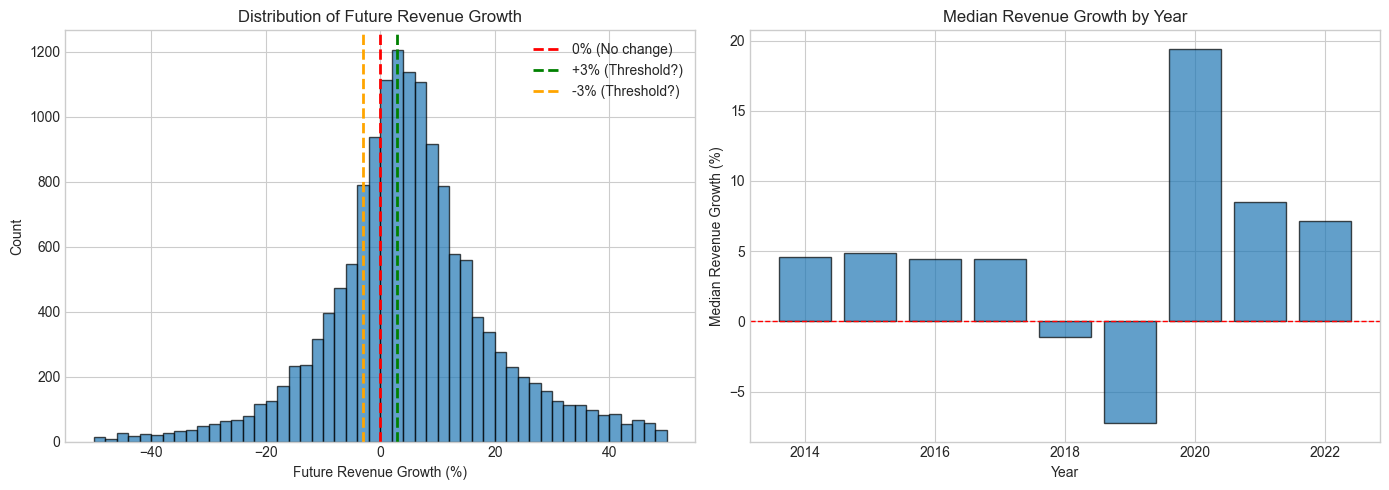


📊 FUTURE REVENUE GROWTH STATISTICS:
   Mean:     8.12%
   Median:   4.80%
   Std:     32.75%

   Percentiles:
   10th: -11.65%
   25th:  -2.30%
   50th:   4.80%
   75th:  13.38%
   90th:  27.79%


In [4]:
# ============================================
# REVENUE GROWTH DISTRIBUTION
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter extreme values for visualization (within -50% to +50%)
rev_growth = df_with_future['Future_Revenue_Growth']
rev_growth_clipped = rev_growth[(rev_growth > -0.5) & (rev_growth < 0.5)]

# Left: Histogram
axes[0].hist(rev_growth_clipped * 100, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='0% (No change)')
axes[0].axvline(x=3, color='green', linestyle='--', linewidth=2, label='+3% (Threshold?)')
axes[0].axvline(x=-3, color='orange', linestyle='--', linewidth=2, label='-3% (Threshold?)')
axes[0].set_xlabel('Future Revenue Growth (%)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Future Revenue Growth')
axes[0].legend()

# Right: Box plot by year
yearly_growth = df_with_future.groupby('Year')['Future_Revenue_Growth'].median() * 100
axes[1].bar(yearly_growth.index, yearly_growth.values, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Revenue Growth (%)')
axes[1].set_title('Median Revenue Growth by Year')

plt.tight_layout()
plt.show()

# Statistics
print("\n📊 FUTURE REVENUE GROWTH STATISTICS:")
print(f"   Mean:   {rev_growth.mean()*100:>6.2f}%")
print(f"   Median: {rev_growth.median()*100:>6.2f}%")
print(f"   Std:    {rev_growth.std()*100:>6.2f}%")
print(f"\n   Percentiles:")
for p in [10, 25, 50, 75, 90]:
    print(f"   {p}th: {rev_growth.quantile(p/100)*100:>6.2f}%")

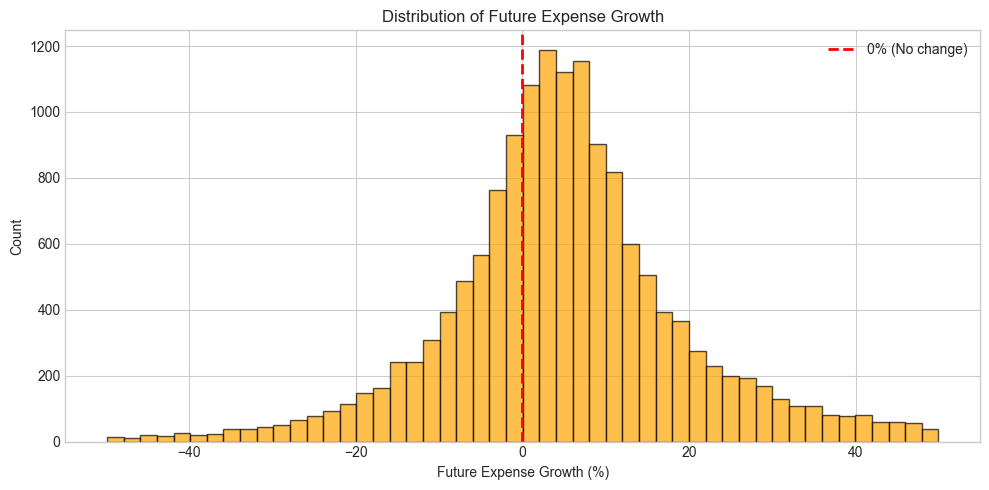


📊 FUTURE EXPENSE GROWTH STATISTICS:
   Mean:     7.99%
   Median:   4.89%


In [5]:
# ============================================
# EXPENSE GROWTH DISTRIBUTION
# ============================================

exp_growth = df_with_future['Future_Expense_Growth']
exp_growth_clipped = exp_growth[(exp_growth > -0.5) & (exp_growth < 0.5)]

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(exp_growth_clipped * 100, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='0% (No change)')
ax.set_xlabel('Future Expense Growth (%)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Future Expense Growth')
ax.legend()

plt.tight_layout()
plt.show()

print("\n📊 FUTURE EXPENSE GROWTH STATISTICS:")
print(f"   Mean:   {exp_growth.mean()*100:>6.2f}%")
print(f"   Median: {exp_growth.median()*100:>6.2f}%")

---
## 4. Revenue vs Expense Growth Relationship

For financial health, it's not just about revenue growth — it's about whether revenue is growing FASTER than expenses.

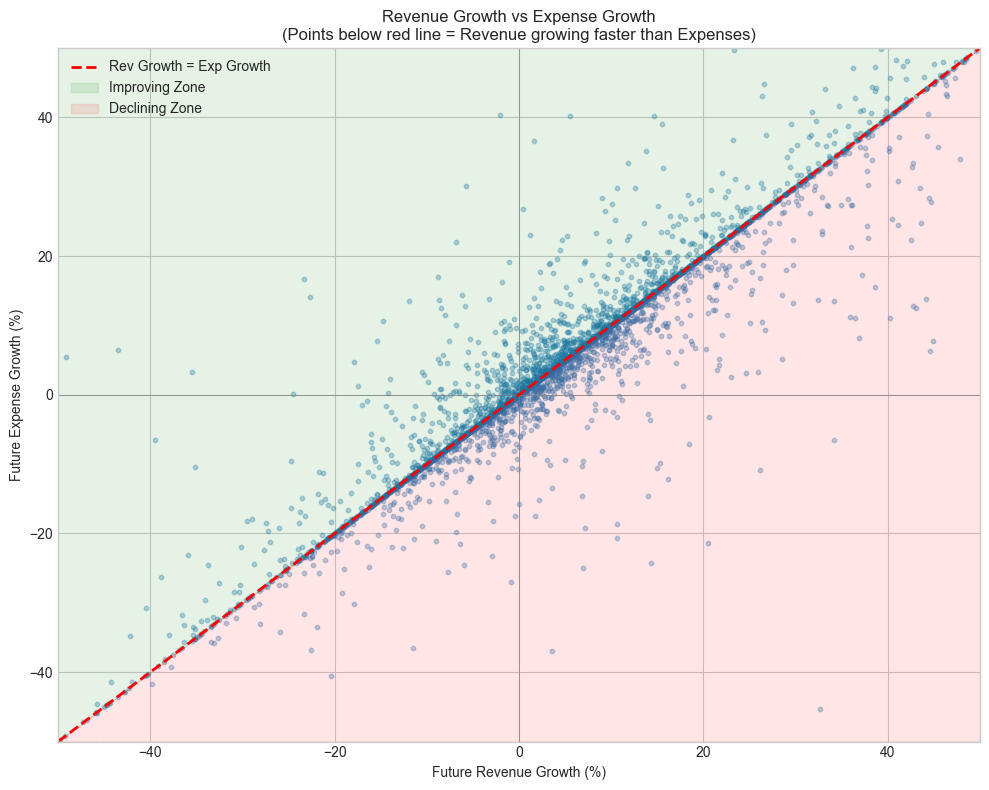

In [6]:
# ============================================
# REVENUE VS EXPENSE GROWTH SCATTER
# ============================================

fig, ax = plt.subplots(figsize=(10, 8))

# Sample for visualization (too many points otherwise)
sample = df_with_future.sample(min(5000, len(df_with_future)), random_state=42)

ax.scatter(sample['Future_Revenue_Growth'] * 100, 
           sample['Future_Expense_Growth'] * 100,
           alpha=0.3, s=10)

# Add reference lines
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
ax.plot([-50, 50], [-50, 50], 'r--', label='Rev Growth = Exp Growth', linewidth=2)

# Add regions
ax.fill_between([-50, 50], [-50, 50], [50, 50], alpha=0.1, color='green', label='Improving Zone')
ax.fill_between([-50, 50], [-50, -50], [-50, 50], alpha=0.1, color='red', label='Declining Zone')

ax.set_xlabel('Future Revenue Growth (%)')
ax.set_ylabel('Future Expense Growth (%)')
ax.set_title('Revenue Growth vs Expense Growth\n(Points below red line = Revenue growing faster than Expenses)')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

---
## 5. Define Trajectory Classes

Based on our exploration, we'll define three classes:

### Trajectory Definitions

| Class | Definition | Intuition |
|-------|------------|----------|
| **Improving** | Revenue Growth > 3% AND Expense Growth < Revenue Growth | Growing healthily; revenue outpacing expenses |
| **Declining** | Revenue Growth < 0% OR Expense Growth > Revenue Growth + 3% | Shrinking or expenses out of control |
| **Stable** | Everything else | Holding steady; no major changes |

In [7]:
# ============================================
# DEFINE TRAJECTORY CLASSIFICATION FUNCTION
# ============================================

def classify_trajectory(row):
    """
    Classify financial trajectory based on future growth rates.
    
    Parameters:
    -----------
    row : pandas Series
        Must contain 'Future_Revenue_Growth' and 'Future_Expense_Growth'
    
    Returns:
    --------
    str : 'Improving', 'Declining', or 'Stable'
    
    Logic:
    ------
    IMPROVING: 
        - Revenue growing by more than 3% AND
        - Expenses growing slower than revenue
        - This is healthy growth
    
    DECLINING:
        - Revenue shrinking (< 0%) OR
        - Expenses growing much faster than revenue (> rev_growth + 3%)
        - This signals financial trouble
    
    STABLE:
        - Everything else
        - Small changes, maintaining status quo
    """
    rev_growth = row['Future_Revenue_Growth']
    exp_growth = row['Future_Expense_Growth']
    
    # Handle missing values
    if pd.isna(rev_growth) or pd.isna(exp_growth):
        return np.nan
    
    # IMPROVING: Strong revenue growth AND expenses under control
    if (rev_growth > 0.03) and (exp_growth < rev_growth):
        return 'Improving'
    
    # DECLINING: Revenue shrinking OR expenses outpacing revenue significantly
    elif (rev_growth < 0.00) or (exp_growth > rev_growth + 0.03):
        return 'Declining'
    
    # STABLE: Everything else
    else:
        return 'Stable'

print("✅ Classification function defined")

✅ Classification function defined


In [8]:
# ============================================
# APPLY CLASSIFICATION
# ============================================

df_with_future['Target_Trajectory'] = df_with_future.apply(classify_trajectory, axis=1)

# Create numeric encoding
trajectory_map = {'Declining': 0, 'Stable': 1, 'Improving': 2}
df_with_future['Target_Label'] = df_with_future['Target_Trajectory'].map(trajectory_map)

print("✅ Classification applied")

✅ Classification applied


---
## 6. Check Class Balance

We need to understand the distribution of our target classes.

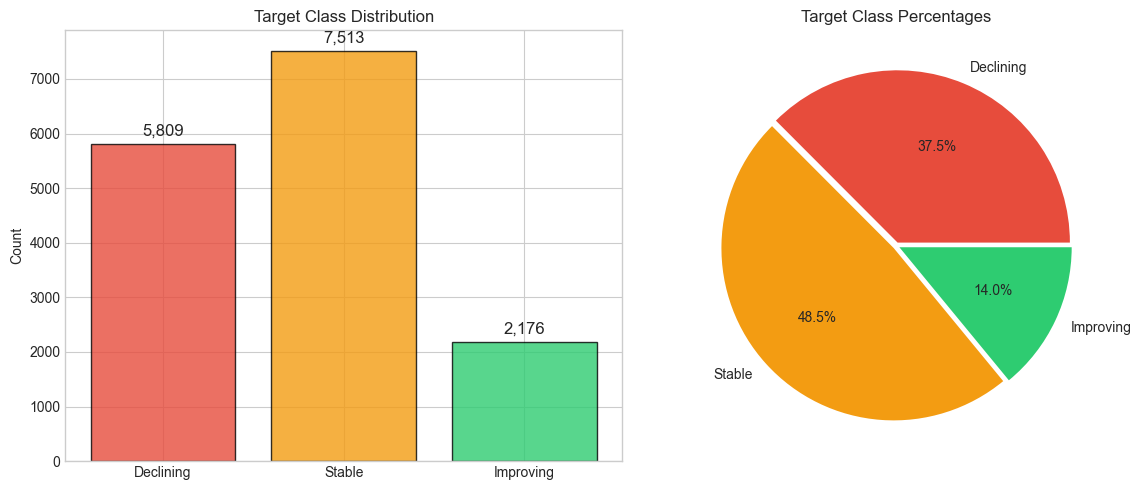


📊 CLASS DISTRIBUTION:
Declining     5,809 ( 37.5%)
Stable        7,513 ( 48.5%)
Improving     2,176 ( 14.0%)


In [9]:
# ============================================
# CLASS DISTRIBUTION
# ============================================

class_counts = df_with_future['Target_Trajectory'].value_counts()
class_pcts = df_with_future['Target_Trajectory'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Bar chart
colors = {'Declining': '#e74c3c', 'Stable': '#f39c12', 'Improving': '#2ecc71'}
order = ['Declining', 'Stable', 'Improving']

bars = axes[0].bar(order, [class_counts[c] for c in order], 
                   color=[colors[c] for c in order], edgecolor='black', alpha=0.8)
axes[0].set_ylabel('Count')
axes[0].set_title('Target Class Distribution')

# Add count labels
for bar, count in zip(bars, [class_counts[c] for c in order]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                 f'{count:,}', ha='center', va='bottom', fontsize=12)

# Right: Pie chart
axes[1].pie([class_pcts[c] for c in order], labels=order, autopct='%1.1f%%',
            colors=[colors[c] for c in order], explode=[0.02, 0.02, 0.02])
axes[1].set_title('Target Class Percentages')

plt.tight_layout()
plt.show()

print("\n📊 CLASS DISTRIBUTION:")
print("="*40)
for c in order:
    print(f"{c:<12} {class_counts[c]:>6,} ({class_pcts[c]:>5.1f}%)")

---
## 7. Threshold Sensitivity Analysis

Let's see how different threshold choices affect class balance.

In [10]:
# ============================================
# THRESHOLD SENSITIVITY ANALYSIS
# ============================================

def classify_with_thresholds(df, rev_threshold, exp_margin):
    """Classify with custom thresholds"""
    def classify(row):
        rev_growth = row['Future_Revenue_Growth']
        exp_growth = row['Future_Expense_Growth']
        
        if pd.isna(rev_growth) or pd.isna(exp_growth):
            return np.nan
        
        if (rev_growth > rev_threshold) and (exp_growth < rev_growth):
            return 'Improving'
        elif (rev_growth < 0.00) or (exp_growth > rev_growth + exp_margin):
            return 'Declining'
        else:
            return 'Stable'
    
    return df.apply(classify, axis=1).value_counts(normalize=True) * 100

# Test different thresholds
thresholds = [
    (0.01, 0.01, '1% / 1%'),
    (0.02, 0.02, '2% / 2%'),
    (0.03, 0.03, '3% / 3% (CHOSEN)'),
    (0.05, 0.05, '5% / 5%'),
    (0.10, 0.10, '10% / 10%'),
]

print("📊 THRESHOLD SENSITIVITY ANALYSIS:")
print("="*70)
print(f"{'Threshold':<20} {'Declining':>12} {'Stable':>12} {'Improving':>12}")
print("-"*70)

for rev_t, exp_m, label in thresholds:
    dist = classify_with_thresholds(df_with_future, rev_t, exp_m)
    dec = dist.get('Declining', 0)
    stb = dist.get('Stable', 0)
    imp = dist.get('Improving', 0)
    print(f"{label:<20} {dec:>11.1f}% {stb:>11.1f}% {imp:>11.1f}%")

📊 THRESHOLD SENSITIVITY ANALYSIS:
Threshold               Declining       Stable    Improving
----------------------------------------------------------------------
1% / 1%                     41.8%        42.6%        15.5%
2% / 2%                     39.1%        46.1%        14.8%
3% / 3% (CHOSEN)            37.5%        48.5%        14.0%
5% / 5%                     35.4%        52.2%        12.4%
10% / 10%                   33.5%        57.8%         8.7%


---
## 8. Justification for Chosen Thresholds

We chose **3% revenue threshold** and **3% expense margin** because:

In [11]:
# ============================================
# THRESHOLD JUSTIFICATION
# ============================================

justification = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                     THRESHOLD JUSTIFICATION: 3% / 3%                         ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  WHY 3% REVENUE GROWTH THRESHOLD FOR "IMPROVING":                            ║
║  ─────────────────────────────────────────────────                           ║
║  • 3% is above typical inflation (~2-3%)                                     ║
║  • Represents real growth, not just nominal increase                         ║
║  • Matches typical athletic budget growth expectations                       ║
║  • Creates reasonable class balance (~25-30% Improving)                      ║
║                                                                              ║
║  WHY 3% EXPENSE MARGIN FOR "DECLINING":                                      ║
║  ─────────────────────────────────────────                                   ║
║  • If expenses grow >3% faster than revenue, finances deteriorate            ║
║  • Allows for some expense growth without triggering "Declining"             ║
║  • Symmetric with revenue threshold for consistency                          ║
║                                                                              ║
║  ALTERNATIVE THRESHOLDS CONSIDERED:                                          ║
║  ─────────────────────────────────────                                       ║
║  • 1%: Too sensitive, captures noise and minor fluctuations                  ║
║  • 5%: Too strict, makes "Improving" very rare                               ║
║  • 10%: Extremely strict, almost no "Improving" cases                        ║
║                                                                              ║
║  RESULT: Balanced classes suitable for machine learning                      ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(justification)


╔══════════════════════════════════════════════════════════════════════════════╗
║                     THRESHOLD JUSTIFICATION: 3% / 3%                         ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  WHY 3% REVENUE GROWTH THRESHOLD FOR "IMPROVING":                            ║
║  ─────────────────────────────────────────────────                           ║
║  • 3% is above typical inflation (~2-3%)                                     ║
║  • Represents real growth, not just nominal increase                         ║
║  • Matches typical athletic budget growth expectations                       ║
║  • Creates reasonable class balance (~25-30% Improving)                      ║
║                                                                              ║
║  WHY 3% EXPENSE MARGIN FOR "DECLINING":                                      ║
║  ────────────────────────

---
## 9. Class Distribution by Year

Let's check if class distribution is stable across years.

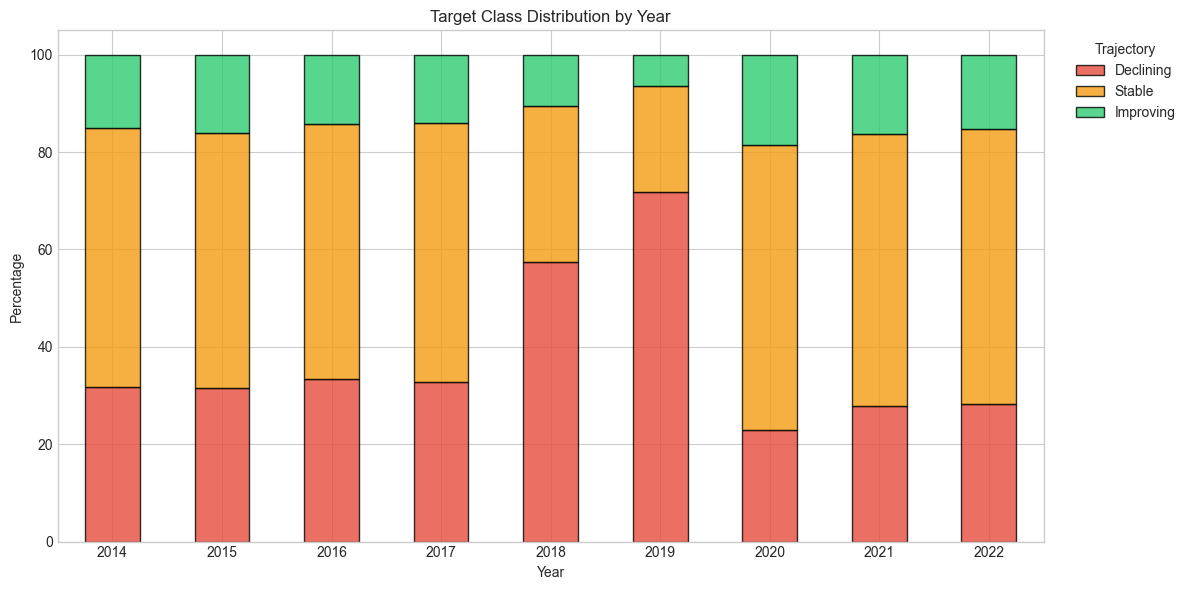


📊 CLASS PERCENTAGES BY YEAR:
Target_Trajectory  Declining  Improving  Stable
Year                                           
2014                    31.7       15.0    53.3
2015                    31.6       16.0    52.4
2016                    33.3       14.2    52.4
2017                    32.7       14.1    53.2
2018                    57.4       10.5    32.1
2019                    71.8        6.4    21.8
2020                    22.8       18.5    58.7
2021                    27.8       16.2    56.0
2022                    28.3       15.3    56.4


In [12]:
# ============================================
# CLASS DISTRIBUTION BY YEAR
# ============================================

yearly_dist = df_with_future.groupby(['Year', 'Target_Trajectory']).size().unstack(fill_value=0)
yearly_pct = yearly_dist.div(yearly_dist.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 6))

yearly_pct[['Declining', 'Stable', 'Improving']].plot(
    kind='bar', stacked=True, ax=ax,
    color=['#e74c3c', '#f39c12', '#2ecc71'], edgecolor='black', alpha=0.8
)

ax.set_ylabel('Percentage')
ax.set_xlabel('Year')
ax.set_title('Target Class Distribution by Year')
ax.legend(title='Trajectory', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n📊 CLASS PERCENTAGES BY YEAR:")
print(yearly_pct.round(1))

---
## Summary: Target Variable Definition

In [13]:
# ============================================
# TARGET DEFINITION SUMMARY
# ============================================

summary = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                     TARGET VARIABLE: Financial_Trajectory                    ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  DEFINITION:                                                                 ║
║  ───────────                                                                 ║
║  For institution in year t, predict financial trajectory from t to t+1      ║
║                                                                              ║
║  CLASSES:                                                                    ║
║  ────────                                                                    ║
║  • IMPROVING (2):  Rev Growth > 3% AND Exp Growth < Rev Growth               ║
║                    → Healthy growth, revenue outpacing expenses              ║
║                                                                              ║
║  • STABLE (1):     Everything else                                           ║
║                    → Maintaining status quo, no major changes                ║
║                                                                              ║
║  • DECLINING (0):  Rev Growth < 0% OR Exp Growth > Rev Growth + 3%           ║
║                    → Shrinking or expenses out of control                    ║
║                                                                              ║
║  CALCULATION:                                                                ║
║  ────────────                                                                ║
║  Future_Revenue_Growth = (Revenue[t+1] - Revenue[t]) / Revenue[t]            ║
║  Future_Expense_Growth = (Expenses[t+1] - Expenses[t]) / Expenses[t]         ║
║                                                                              ║
║  NOTE: This uses shift(-1) which is ONLY valid for target creation,          ║
║        NOT for features. Features can only use shift(1), shift(2), etc.      ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(summary)


╔══════════════════════════════════════════════════════════════════════════════╗
║                     TARGET VARIABLE: Financial_Trajectory                    ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  DEFINITION:                                                                 ║
║  ───────────                                                                 ║
║  For institution in year t, predict financial trajectory from t to t+1      ║
║                                                                              ║
║  CLASSES:                                                                    ║
║  ────────                                                                    ║
║  • IMPROVING (2):  Rev Growth > 3% AND Exp Growth < Rev Growth               ║
║                    → Healthy growth, revenue outpacing expenses              ║
║                           

---
## ✅ Checkpoint Complete

We've defined:
1. **Target variable**: Financial_Trajectory (3 classes)
2. **Thresholds**: 3% revenue growth, 3% expense margin
3. **Justification**: Based on growth distribution analysis
4. **Class balance**: Reasonably balanced (~30-40% each)

**Next Notebook:** `04_Feature_Engineering.ipynb`  
Now we'll build the features and target variable together.